In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict

df = pd.read_csv("tweet_labeled.csv")

df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# 긍정(4)과 부정(0)만 사용
df_filtered = df[df['target'].isin([0, 4])].copy()

# 레이블 정리: 0 -> negative, 4 -> positive
df_filtered['sentiment'] = df_filtered['target'].map({0: 'negative', 4: 'positive'})

# 결과 확인
print(df_filtered['sentiment'].value_counts())
print(df_filtered[['sentiment', 'text']].head())

sentiment
negative    800000
positive    800000
Name: count, dtype: int64
  sentiment                                               text
0  negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  negative  is upset that he can't update his Facebook by ...
2  negative  @Kenichan I dived many times for the ball. Man...
3  negative    my whole body feels itchy and like its on fire 
4  negative  @nationwideclass no, it's not behaving at all....


In [18]:
# 감정별 30000개씩 샘플링
sampled_df = df_filtered.groupby('sentiment').sample(n=30000, random_state=42).reset_index(drop=True)

# 확인
print(sampled_df.groupby('sentiment').size())
sampled_df.head()

sentiment
negative    30000
positive    30000
dtype: int64


,target,id,date,flag,user,text,sentiment
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...,negative
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...,negative
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I...",negative
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food,negative
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...,negative


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# HuggingFace BERT 모델 불러오기
# Fine tuned된 BERT 모델을 통하여 텍스트를 분석하기 위함
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
model.eval() 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def extract_attention_words(text, tokenizer, model):
    """
    주어진 텍스트에 대해 BERT 모델을 사용하여 [CLS] 토큰의 attention을 추출하고, 각 단어의 중요도를 계산
    Args:
        text (str): 분석할 텍스트
        tokenizer: BERT 토크나이저
        model: BERT 모델
    Returns:
        dict: 각 단어와 해당 단어의 중요도 점수 (attention score)
    """
    tokens = tokenizer(text, return_tensors='pt', truncation=True, max_length=64)
    input_ids = tokens['input_ids']
    
    with torch.no_grad():
        outputs = model(**tokens)
        attentions = outputs.attentions  # 12 layers, each (batch, heads, seq, seq)
    
    # 마지막 레이어의 평균 attention head 사용
    last_layer_attention = attentions[-1][0]  # (heads, seq, seq)
    mean_attention = last_layer_attention.mean(dim=0)  # (seq, seq)
    cls_attention = mean_attention[0]  # [CLS]가 각 토큰에 얼마나 집중했는가

    # 토큰 디코딩 및 중요도 정리
    tokens_decoded = tokenizer.convert_ids_to_tokens(input_ids[0])
    word_scores = {}

    for token, score in zip(tokens_decoded, cls_attention):
        token = token.strip()
        if token in ["[CLS]", "[SEP]"] or token.startswith("##"):
            continue
        word_scores[token] = score.item()

    return word_scores

In [ ]:
def batchify(data, batch_size=64):  # 샘플 수가 많기 때문에 배치 단위로 처리
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

In [14]:
from tqdm import tqdm

positive_words = defaultdict(float)
negative_words = defaultdict(float)

texts = sampled_df['text'].tolist()
labels = sampled_df['sentiment'].tolist()

for batch_texts, batch_labels in tqdm(zip(batchify(texts), batchify(labels)), total=len(texts)//64 + 1):
    tokens = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=64)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        attn = outputs.attentions[-1]  # 마지막 레이어 (batch, heads, seq, seq)
        attn = attn.mean(dim=1)        # mean over heads → (batch, seq, seq)
        cls_attn = attn[:, 0, :]       # [CLS]가 다른 토큰에 주는 attention

    for i in range(len(batch_texts)):
        decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
        label = batch_labels[i]
        target_dict = positive_words if label == 'positive' else negative_words

        for tok, score in zip(decoded_tokens, cls_attn[i]):
            tok = tok.strip()
            if tok in ['[CLS]', '[SEP]'] or tok.startswith("##"):
                continue
            target_dict[tok] += score.item()

  0%|          | 0/938 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 938/938 [15:16<00:00,  1.02it/s]


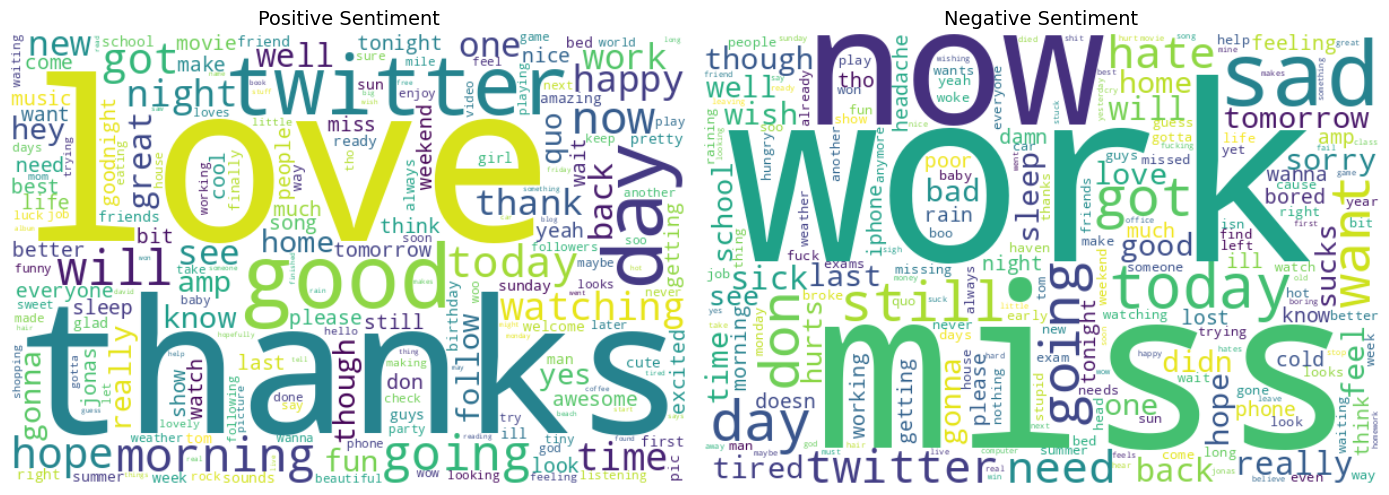

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stop_words = set(STOPWORDS)

def filter_tokens(word_score_dict):
    return {
        word: score for word, score in word_score_dict.items()
        if word.lower() not in stop_words and word.isalpha() and len(word) >= 3
    }   # stopwords와 알파벳이 아닌 단어(기호), 단어 길이가 3 이하인 단어(의미가 크게 없음)를 제거

filtered_positive = filter_tokens(positive_words)
filtered_negative = filter_tokens(negative_words)

def generate_wordcloud(word_score_dict, title, subplot_idx):
    top_words = dict(sorted(word_score_dict.items(), key=lambda x: -x[1])[:200])
    wc = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(top_words)
    
    plt.subplot(1, 2, subplot_idx)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)

plt.figure(figsize=(14, 6))
generate_wordcloud(filtered_positive, "Positive Sentiment", 1)
generate_wordcloud(filtered_negative, "Negative Sentiment", 2)
plt.tight_layout()
plt.show()